https://www.kaggle.com/datasets/antoreepjana/animals-detection-images-dataset/

The dataset downloaded from Kaggle is a zipfile containing 2 folders: Train and Test

In [6]:
import zipfile

#Open archive.zip
with zipfile.ZipFile('archive.zip','r') as zip_ref:
    #Extract the files
    zip_ref.extractall()

After extracting the zipfiles, we will combine both Train and Test folders and get rid of 'Label' subfolders and work with the images only.

In [11]:

import os
import shutil

# define a function to ignore the 'Label' subfolder
def ignore_labels_dir(dir, contents):
    if 'Label' in contents:
        return ['Label']
    return []

# specify the paths to the main directories 'A' and 'B'
dir_A = 'test'
dir_B = 'train'

# specify the path to the new combined directory
dir_AB = 'images'

# create the combined directory
os.makedirs(dir_AB, exist_ok=True)

# copy the contents of directory A to directory AB
for subdir, dirs, files in os.walk(dir_A):
    subdir_relpath = os.path.relpath(subdir, dir_A)
    dest_subdir = os.path.join(dir_AB, subdir_relpath)
    os.makedirs(dest_subdir, exist_ok=True)
    files_to_copy = [f for f in files if not f.endswith('.txt')]
    for f in files_to_copy:
        src_file = os.path.join(subdir, f)
        dest_file = os.path.join(dest_subdir, f)
        shutil.copy2(src_file, dest_file)

# copy the contents of directory B to directory AB
for subdir, dirs, files in os.walk(dir_B):
    subdir_relpath = os.path.relpath(subdir, dir_B)
    dest_subdir = os.path.join(dir_AB, subdir_relpath)
    os.makedirs(dest_subdir, exist_ok=True)
    files_to_copy = [f for f in files if not f.endswith('.txt')]
    for f in files_to_copy:
        src_file = os.path.join(subdir, f)
        dest_file = os.path.join(dest_subdir, f)
        shutil.copy2(src_file, dest_file)

# iterate over all subdirectories in dir_AB
for root, dirs, files in os.walk(dir_AB):
    for dir in dirs:
        if dir == 'Label':
            os.rmdir(os.path.join(root, dir))


In [5]:
#Import required libraries
import keras
import numpy as np
from glob import glob
from tqdm import tqdm 

# Data
from keras.preprocessing.image import ImageDataGenerator

# Data Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Model
from keras import Sequential
from keras.models import load_model
from keras.layers import Dense, GlobalAvgPool2D as GAP, Dropout

# Callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Transfer Learning Models
from tensorflow.keras.applications import ResNet152V2, InceptionV3

In [6]:
# Main Path
path = 'images'

# Get Class Names
class_names = sorted(os.listdir(path))
n_classes = len(class_names)
print(f"Class Names: \n{class_names}")
print(f"Total Number of Classes : {n_classes}")

Class Names: 
['Bear', 'Brown bear', 'Bull', 'Butterfly', 'Camel', 'Canary', 'Caterpillar', 'Cattle', 'Centipede', 'Cheetah', 'Chicken', 'Crab', 'Crocodile', 'Deer', 'Duck', 'Eagle', 'Elephant', 'Fish', 'Fox', 'Frog', 'Giraffe', 'Goat', 'Goldfish', 'Goose', 'Hamster', 'Harbor seal', 'Hedgehog', 'Hippopotamus', 'Horse', 'Jaguar', 'Jellyfish', 'Kangaroo', 'Koala', 'Ladybug', 'Leopard', 'Lion', 'Lizard', 'Lynx', 'Magpie', 'Monkey', 'Moths and butterflies', 'Mouse', 'Mule', 'Ostrich', 'Otter', 'Owl', 'Panda', 'Parrot', 'Penguin', 'Pig', 'Polar bear', 'Rabbit', 'Raccoon', 'Raven', 'Red panda', 'Rhinoceros', 'Scorpion', 'Sea lion', 'Sea turtle', 'Seahorse', 'Shark', 'Sheep', 'Shrimp', 'Snail', 'Snake', 'Sparrow', 'Spider', 'Squid', 'Squirrel', 'Starfish', 'Swan', 'Tick', 'Tiger', 'Tortoise', 'Turkey', 'Turtle', 'Whale', 'Woodpecker', 'Worm', 'Zebra']
Total Number of Classes : 80


In [7]:
class_dis = [len(os.listdir(path + f"/{name}")) for name in class_names]
print(f"Class Distribution : \n{class_dis}")

Class Distribution : 
[126, 147, 120, 2045, 94, 129, 564, 241, 237, 167, 525, 423, 184, 504, 630, 897, 188, 1452, 217, 665, 321, 296, 164, 322, 133, 301, 129, 98, 543, 138, 549, 141, 80, 427, 180, 308, 1460, 114, 94, 1091, 1458, 234, 97, 212, 136, 476, 110, 601, 438, 286, 284, 342, 154, 139, 87, 248, 124, 236, 326, 40, 361, 173, 107, 484, 775, 606, 1063, 28, 435, 303, 297, 75, 339, 498, 129, 29, 339, 203, 143, 212]


In [11]:
fig = px.pie(names=class_names, values=class_dis)
fig.update_layout({"title":{'text':"Class Distribution","x":0.2}}, width=1175, height=1500)
fig.show()

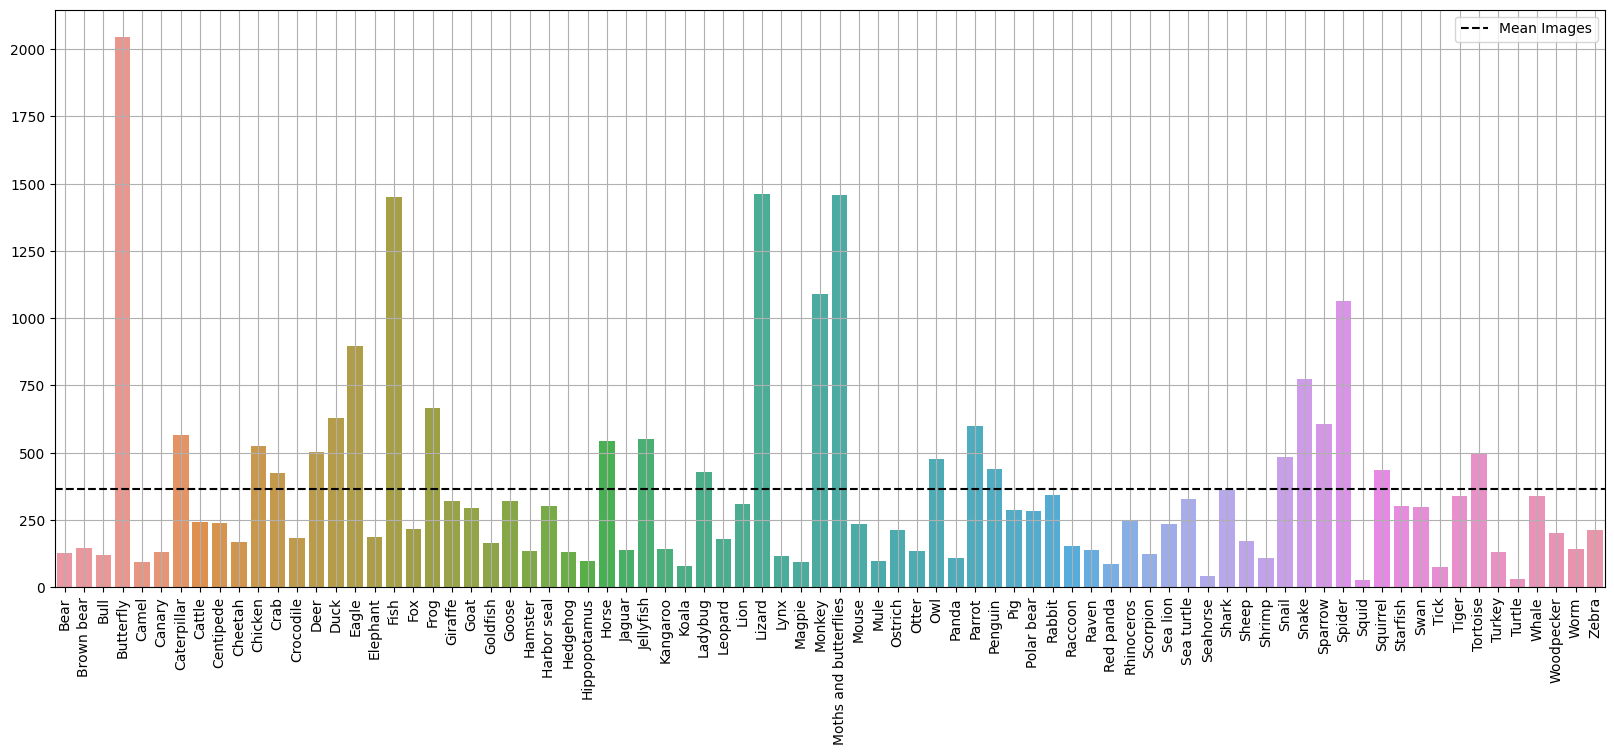

In [12]:
plt.figure(figsize=(20,7.5))
sns.barplot(x=class_names, y=class_dis)
plt.grid()
plt.axhline(np.mean(class_dis), color='k', linestyle='--', label="Mean Images")
# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)
plt.legend()
plt.show()

Classes are not equally distributed. Data augmentation needs to be done to ensure all classes are equal inorder to avoid model bias

In [13]:
# Initialize Generator 
gen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True, 
    vertical_flip=True, 
    rotation_range=20, 
    validation_split=0.2)

# Load data
train_ds = gen.flow_from_directory(
    path, 
    target_size=(256,256), 
    class_mode='binary', 
    batch_size=64, 
    shuffle=True, 
    subset='training')

valid_ds = gen.flow_from_directory(
    path, 
    target_size=(256,256), 
    class_mode='binary', 
    batch_size=64, 
    shuffle=True, 
    subset='validation')

Found 23292 images belonging to 80 classes.
Found 5779 images belonging to 80 classes.


In [ ]:
# Specify Model Name
name = "ResNet_Model"

 # Pretrained Model
base_model = ResNet152V2(include_top=False, input_shape=(256,256,3), weights='imagenet')
base_model.trainable = False # Freeze the Weights

 # Model 
resnet152V2 = Sequential([
     base_model,
     GAP(),
     Dense(256, activation='relu'),
     Dropout(0.2),
     Dense(n_classes, activation='softmax')
 ], name=name)

 # Compile
resnet152V2.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
 )

 # Callbacks 
cbs = [
     EarlyStopping(patience=3, restore_best_weights=True),
     ModelCheckpoint(name + ".h5", save_best_only=True)
 ]

  #Train Model
resnet152V2.fit(
     train_ds, validation_data=valid_ds,
     epochs=50, callbacks=cbs
 )

234545216/234545216 [==============================] - 11s 0us/step
Epoch 1/50
364/364 [==============================] - 1083s 3s/step - loss: 1.4569 - accuracy: 0.6225 - val_loss: 1.0860 - val_accuracy: 0.6894
Epoch 2/50
364/364 [==============================] - 1068s 3s/step - loss: 0.9702 - accuracy: 0.7153 - val_loss: 1.0060 - val_accuracy: 0.7091
Epoch 3/50
364/364 [==============================] - 1068s 3s/step - loss: 0.8572 - accuracy: 0.7406 - val_loss: 0.9900 - val_accuracy: 0.7057
Epoch 4/50
364/364 [==============================] - 1119s 3s/step - loss: 0.7948 - accuracy: 0.7530 - val_loss: 0.9709 - val_accuracy: 0.7133
Epoch 5/50
364/364 [==============================] - 1089s 3s/step - loss: 0.7517 - accuracy: 0.7641 - val_loss: 0.9195 - val_accuracy: 0.7313
Epoch 6/50
364/364 [==============================] - 1083s 3s/step - loss: 0.7100 - accuracy: 0.7711 - val_loss: 0.9370 - val_accuracy: 0.7264
Epoch 7/50
364/364 [==============================] - 1078s 3s/step 

Saved our model as 'ResNet_Model.h5'

In [ ]:
# # Specify Model Name
# name = "Inception_Model"

# # Pretrained Model
# base_model = InceptionV3(include_top=False, input_shape=(256,256,3), weights='imagenet')
# base_model.trainable = False # Freeze the Weights

# # Model 
# inception = Sequential([
#     base_model,
#     GAP(),
#     Dense(256, activation='relu'),
#     Dropout(0.2),
#     Dense(n_classes, activation='softmax')
# ], name=name)

# # Compile
# inception.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer='adam',
#     metrics=['accuracy']
# )

# # Callbacks 
# cbs = [
#     EarlyStopping(patience=3, restore_best_weights=True),
#     ModelCheckpoint(name + ".h5", save_best_only=True)
# ]

# # Train Model
# inception.fit(
#     train_ds, validation_data=valid_ds,
#     epochs=50, callbacks=cbs
# )

Results from the InceptionV3 model which were slightly less accurate

Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/inception_v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/50
364/364 [==============================] - 1028s 3s/step - loss: 1.5746 - accuracy: 0.6118 - val_loss: 1.1680 - val_accuracy: 0.6783
Epoch 2/50
364/364 [==============================] - 1045s 3s/step - loss: 1.0859 - accuracy: 0.6961 - val_loss: 1.0680 - val_accuracy: 0.6982
Epoch 3/50
364/364 [==============================] - 1080s 3s/step - loss: 0.9990 - accuracy: 0.7067 - val_loss: 1.0406 - val_accuracy: 0.7020
Epoch 4/50
364/364 [==============================] - 991s 3s/step - loss: 0.9404 - accuracy: 0.7249 - val_loss: 0.9716 - val_accuracy: 0.7250
Epoch 5/50
364/364 [==============================] - 1009s 3s/step - loss: 0.9080 - accuracy: 0.7296 - val_loss: 0.9954 - val_accuracy: 0.7038


In [14]:
model = load_model('ResNet_Model.h5')
model.summary()

Model: "ResNet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 80)                20560     
                                                                 
Total params: 58,876,752
Trainable params: 545,104
Non-trainable params: 58,331,648
____________________________________